<!---
layout: post
title: Influence Maximization in Python - Greedy vs CELF
tags: 
- Python
- igraph
- Network Analysis
--->

<center> <h1>Influence Maximization in Python - Greedy vs. CELF</h1> </center>

Influence Maximization (IM) is a field of network analysis that has an enormous range of applications from viral marketing to disease modelling and public health interventions. IM is the task of finding a set of seed nodes in a network such that the resulting "influence" propagation reaches the largest number of nodes in the network. "Influence" in this case can represent anything that can be passed across connected peers within a network, such as information, behavior, disease or product adoption.

[Kempe et al. (2003)](https://www.cs.cornell.edu/home/kleinber/kdd03-inf.pdf) were the first to formalize IM as a combinatorial optimization problem, which can be expressed informally as follows: Given a network with $N$ nodes and given a "spreading" or propagation process on that network, choose a "seed set" $S$ of size $k$<$N$ to maximize the number of nodes in the network that are ultimately influenced.

Solving this problem turns out to be extremely computationally burdensome. For example, in a relatively small network of 1,000 nodes, there are more than 8 trillion different possible candidates of $k=5$ seed sets $\left(n\choose k\right)$, which is impossible to solve even on state-of-the-art high performance computing resources. Consequently, a very active literature over the last 15 years has been dedicated to finding approximate solutions to the problem that can be solved quickly. This post walks through how to implement two of the earliest and most fundamental approximation algorithms in Python - the Greedy and the CELF algorithms - and compares their performance.

We begin by loading a few modules, including the [`igraph`](http://igraph.org/python/) package to model our networks. Another popular network modelling package is  [`NetworkX`](https://networkx.github.io/).

In [2]:
from random import uniform, seed
import numpy as np
import time
from igraph import *

## Spread Process - Independent Cascade

IM algorithms solve the optimization problem for a given spread or propagation process. Before getting started with the algorithms themselves, we therefore need to specify a function that simulates the spread of a given seed set across the network. For this post, we will simulate the influence spread using the popular "independent cascade" model, although there are many others we could have chosen, such as the Linear Threshold model. The `IC` function describing the spread process is presented below.

In [7]:
def IC(g,S,p=0.5,mc=1000):
    
    """
    Input: graph object, a set of seed nodes, a propagation probability
    and the number of Monte-Carlo simulations
    Output: Average number of nodes influenced by the seed nodes
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while len(new_active) > 0:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:

                # Construct the probabilities of each out-neighbor being infected
                prob = 1 - (1-p) ** np.array(g.es.select(_source_in = [node])['weight'])
                
                # Determine those neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(prob)) < prob
                new_ones += list(np.extract(success, g.neighbors(node)))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            
        spread.append(len(A))
        
    return(mean(spread))

We calculate the expected spread of a given seed set by taking the average over a large number (`mc`) of Monte-Carlo simulations. The outer loop in the `IC` function iterates over each of these simulations and stores each calculated spread in the `spread` list. The mean of each of these entries, which is a consistent and unbiased estimator for the expected spread of $S$, is then returned as the function output.

Within each MC iteration, we simulate the spread of influence throughout the network over time, where a different "time period" occurs within each of the `while` loop iterations, which simply checks whether any new nodes were activated in the previous time step. If no new nodes were activated (`while len(new_active) == 0`) then the independent cascade process terminates, and the function moves onto the next MC simulation after storing the total spread. 

The third loop performs the actual propagation process on the graph object `g`. For each node `v` that was newly activated in the previous time step, we construct a vector `prob` that contains the probability that `v` activates one of its out-neighbors. We do this by extracting all the edges going between that node and its neighbors by using the `es.select` operation on the graph where the `weight` attribute of each edge can be seen as the number of connections that scale the general independent cascade propagation probability `p`. It then simulates whether an activation occurs by comparing each activation probability with a uniform random draw. (The `np.random.seed(i)` function is used to ensure consistency of results when comparing the processes below.) Those nodes that are successfully activated (`new_ones`) are then selected and if some are not already included within the active set `A` they are added.

## Greedy Algorithm

With our spread function in hand, we can now turn to the IM algorithms themselves. We begin with the **Greedy** algorithm proposed in the seminal [Kempe et al. (2003)](https://www.cs.cornell.edu/home/kleinber/kdd03-inf.pdf) paper. This basically finds the node with the biggest spread, adds it to the seed set and then finds the node with the next biggest marginal spread over and above the spread of the original and so on until $k$ seed nodes are found.

This algorithm only needs to calculate the spread of $\sum_{i=0}^k (N-i)\approx kN$ nodes, which is just 5,000 in the case of our 1,000 node and $k=5$ network (which is a lot less that 8 trillion!). Of course, this computational improvement comes at the cost of the resulting seed set only being an approximate solution to the IM problem because it only considers the incremental spread of the $k$ nodes individually rather than combined. Fortunately, however, the authors show that the algorithm is theoretically guaranteed to choose a seed set whose spread will be at least 63% of the spread of the optimal seed set. It turns out that no other paper has subsequently found a solution with a better approximation (and in fact, most of the algorithms proposed in the literature don't have any theoretical guarantees). The proof of this guarantee is in the paper, but it relies heavily on the fact that the "sub-modular" property of spread functions, which is a kind of set function analogue of concavity, and will be explained in more detail below when we look at the CELF algorithm.

The following `greedy` function implements the algorithm. It produces the optimal set of `k` seed nodes for the graph `g`, and is explained in more detail below.

In [45]:
def greedy(g,k,mc,p=0.1):

    """
    Input: graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
    
    S, spread, timelapse, count = [], [], [], 0
    
    # Find k nodes with largest marginal gain
    for i in range(k):

        count0, start_time = count, time.time()

        # Loop over nodes that are not yet in seed set to find biggest marginal gain
        rangelist = list(set(range(g.vcount()))-set(S))
        count, node = 0, None
        for j in rangelist:

            # Get the spread
            spread = IC(g,S + [j],p,mc)

            # Update the winning node and spread so far
            if spread > count:
                count, node = spread, j

        # Add the selected node to the seed set
        S.append(node)
        
        # Add estimated spread to the
        spread.append(count)
        timelapse.append(time.time() - start_time)

    return(S,spread,list(np.cumsum(timelapse)))

The `greedy` function performs the same operation for all $k$ iterations of the outer `for` loop. Specifically, it calculates the marginal spread for all remaining candidate nodes and then selects the node with the highest spread.

The calculation of the spread for all nodes takes place in the inner `for` loop that iterates over the nodes in `rangelist`, which is computed subtracting the nodes in the current seed set from the full set of nodes `g.vcount()`. Within each iteration, the marginal spread is computed by calling the `IC` function, where the input seed set is equal to the union of $S$ and the current node `j`. The marginal spread for `j` is then compared to the largest spread in the loop so far (`count`) and if it is greater, then that node becomes the current "leader".

The function not only returns the optimal seed set `S` but also the average spread of that seed set along with a list showing the cumulative time taken to complete each iteration (which we'll compare with CELF below).

## CELF Algorithm

The **CELF** algorithm was developed by [Leskovec et al. (2007)](https://www.cs.cmu.edu/~jure/pubs/detect-kdd07.pdf). Although the Greedy algorithm is much quicker than solving the full problem, it is still very slow when used on realisticaly sized networks, and CELF was one of the first significant subsequent improvements.

CELF exploits the sub-modularity property of the spread function, which implies that the marginal spread of a given node in one iteration of the Greedy algorithm cannot be any larger than its marginal spread in the previous iteration. This helps us to choose the nodes for which we evaluate the spread function in a more sophisticated manner, rather than simply evaluating the spread for all nodes. More specifically, in the first round, we calculate the spread for all nodes (like Greedy) and store them in a list, which is then sorted. Naturally, the top node is added to the seed set in the first iteration, and then removed from the list. In the next iteration, only the spread for the top node is calculated. If, after resorting, that node remains at the top of the list, then it must have the highest marginal gain of all nodes. Why? Because we know that if we calculated the marginal gain for all other nodes, they'd be lower than the value currently in the list (due to submodularity) and therefore the "top node" would remain on top. This process continues, finding the node that remains on top after calculating its marginal spread, and then adding it to the seed set. By avoiding calculating the spread for many nodes, CELF turns out to be much faster than Greedy, which we'll show below.

The `celf` function implements the algorithm, which is explained below.

In [46]:
def celf(gr,k,mc,p=0.1):
    
    """
    Input: graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
      
    # --------------------
    # Find the first node with greedy algorithm
    # --------------------
    
    # Calculate the first iteration sorted list
    marg_gain, start_time = [], time.time() 
    for i in range(gr.vcount()):
        marg_gain.append(IC(gr,[i],p,mc))

    # Create the sorted list of nodes and their marginal gain 
    Q = sorted(zip(range(gr.vcount()),marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD, timelapse = [Q[0][0]], Q[0][1], [Q[0][1]], [time.time()-start_time]
    Q, LOOKUPS = Q[1:], [gr.vcount()]
    
    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------
    
    for i in range(k-1):    

        start_time, check, node_lookup = time.time(), False, 0
        
        while check is False:
            node_lookup += 1
            
            # Recalculate spread of top node
            current = Q[0][0]
            
            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(gr,A+[current],p,mc)-spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse=True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)
        
        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,list(np.cumsum(timelapse)),LOOKUPS)

The `celf` function is split into two components. The first component, like the Greedy algorithm, iterates over each node in the graph and selects the node with the highest spread into the seed set. However, it also stores the spreads of each node in the sorted list `Q` for use in the second component.

The second component iterates to find the remaining `k-1` seed nodes. Within each iteration, the algorithm evaluates the marginal spread of the top node in the list `Q` and replaces it within the list. If, after resorting, the top node stays in place (`Q[0][0] == current`) then that node is selected as the next seed node. If not, then the marginal spread of the new top node within `Q` is evaluated and so on.

Like `greedy`, the function returns the optimal seed set, the resulting spread and the time taken to compute each iteration. It also returns the list `LOOKUPS`, which keeps a track of how many spread calculations were performed at each iteration.

## Create Graph

The last step before implementing the algorithms described above is to construct a network. Any `igraph` network object will work, but for the purposes of this post we will use a random Erdos-Renyi graph with 100 nodes and 300 edges. The exact type of graph doesn't matter as the main points hold for any graph.

In [5]:
# Generate Graph
G = Graph.Erdos_Renyi(n=100,m=300)
G.es['weight'] = np.random.uniform(0,1,G.ecount())

Here's what the network looks like.

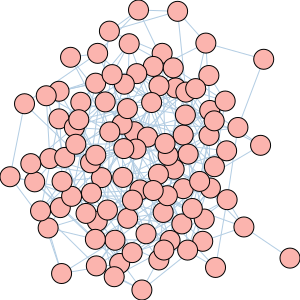

In [56]:
# Plot Graph
layout = G.layout("kk")
G.es["color"] = "#B3CDE3"
G.vs["color"] = "#FBB4AE"
G.vs["label"] = ""
plot(G, bbox = (300, 300),margin = 10,layout = layout)

## Run Algorithms

We now run each of the algorithms. We choose seed set sizes of $k=10$ and choose `mc=1000` simulations. (10,000 simulations are generally used in the literature, but we choose a lower number here so we don't have to wait as long for the results. You may want to try `mc=100` to begin with.)

In [41]:
celf_output = celf(G,10,1000,p=0.1)
greedy_output = greedy(G,10,1000,p=0.1)

## Compare Results

Both approaches should yield identical seed sets, which we can confirm as follows.

In [42]:
print(celf_output[0])
print(greedy_output[0])

[1, 6, 55, 41, 40, 13, 3, 5, 82, 15]
[1, 6, 55, 41, 40, 13, 3, 5, 82, 15]


The seeds are the green nodes pictured below.

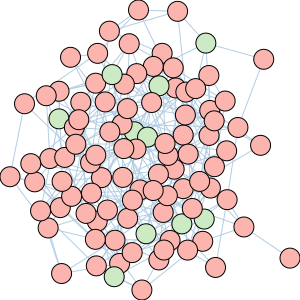

In [57]:
G.vs[celf_output[0]]['color'] = "#CCEBC5"
plot(G, bbox = (300, 300), margin = 10,layout = layout)

Let's now compare the running time of each.

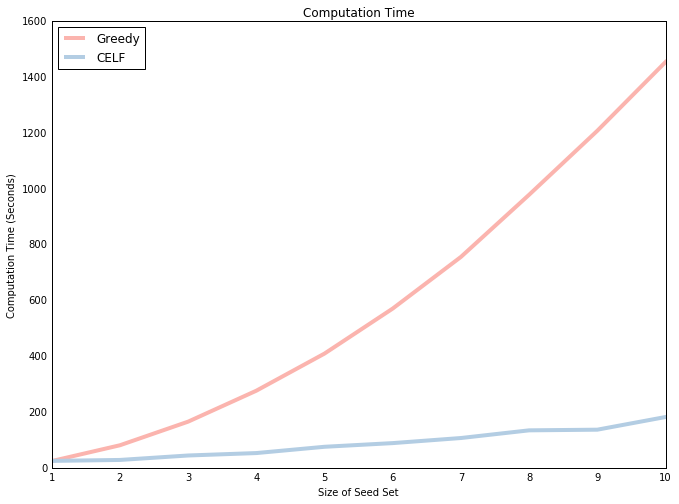

In [58]:
# Plotting packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Get data inputs
y1 = celf_output[2]
y2 = greedy_output[2]
x = range(1,len(y1)+1)

# Plot
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
ax1.plot(x, y2, label="Greedy", color="#FBB4AE",lw=4)
ax1.plot(x, y1, label="CELF",color="#B3CDE3",lw=4)
ax1.legend(loc=2)
plt.ylabel('Computation Time (Seconds)')
plt.xlabel('Size of Seed Set')
plt.title('Computation Time')
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')
plt.show()

We can get some insight into the superior computational efficiency of CELF by observing how many "node lookups" it had to perform during each of the 10 rounds. The list stored in `celf_output[3]` shows that the first round iterated over all 100 nodes of the network. This is identical to Greedy which is why the graph above shows that the running time is equivalent for $k=1$. However, for subsequent iterations, there are far fewer spread computations because the marginal spread of a node in a previous iteration is a good indicator for its marginal spread in a future iteration. Note the relationship between the values below and the corresponding computation time presented in the graph above. There is a visible jump in the blue line for higher values of the "node lookups".

In [40]:
celf_output[3]

[100, 5, 17, 7, 15, 7, 9, 12, 1, 16]

Finally, we plot the resulting expected spread for each seed set size. Note that it is concave, which is consistent with the submodularity of the spread function.

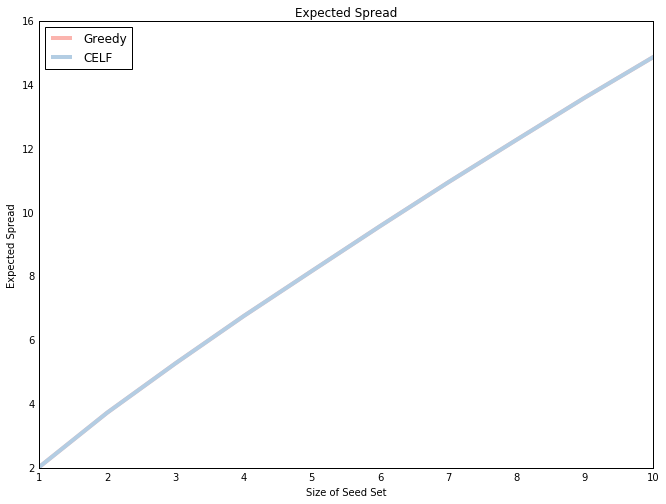

In [59]:
# Get data inputs
y1 = celf_output[1]
y2 = greedy_output[1]
x = range(1,len(y1)+1)

# Plot
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
ax1.plot(x, y2, label="Greedy", color="#FBB4AE",lw=4)
ax1.plot(x, y1, label="CELF",color="#B3CDE3",lw=4)
ax1.legend(loc=2)
plt.ylabel('Expected Spread')
plt.title('Expected Spread')
plt.xlabel('Size of Seed Set')
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')
plt.show()

## Conclusion

We implemented both the Greedy and CELF algorithms as simple Python functions and showed the following:

- Both result in the same seed set
- The CELF algorithm runs a lot faster for any seed set $k>1$.
- The speed arises from the fact that after the first round, CELF performs far fewer spread computations than Greedy.